In [1]:
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 35.9 MB/s eta 0:00:00


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.2 MB/s eta 0:00:00


In [3]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series, plot_correlations, plot_lags
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from pylab import rcParams
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.all import *



%matplotlib inline

/usr/local/lib/python3.9/dist-packages/sktime/utils/validation/_dependencies.py:143: UserWarning: str requires package 'dtw-python' to be present in the python environment, but 'dtw-python' was not found. 'dtw-python' is a soft dependency and not included in the base sktime installation. Please run: `pip install dtw-python` to install the dtw-python package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/sktime/utils/validation/_dependencies.py:143: UserWarning: No module named 'pyod'. 'pyod' is a soft dependency and not included in the base sktime installation. Please run: `pip install pyod` to install the pyod package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/sktime/utils/validation/_dependencies.py:143: UserWarning: No module named 'hmmlearn'. 'hmmlearn.hmm' is a soft dependency and not included in the base sk

In [7]:
from google.colab import drive
drive.mount('/content/drive')

In [25]:
data = pd.read_csv("/content/drive/MyDrive/calls_per_hour.csv")


In [26]:
data

,DATE_TIME,UNIQUE_ID
0,2011-01-01 00:00:00,123
1,2011-01-01 01:00:00,111
2,2011-01-01 02:00:00,81
3,2011-01-01 03:00:00,53
4,2011-01-01 04:00:00,118
...,...,...
52603,2016-12-31 19:00:00,366
52604,2016-12-31 20:00:00,320
52605,2016-12-31 21:00:00,225
52606,2016-12-31 22:00:00,216


In [10]:
duplicates = data[data.duplicated(subset='DATE_TIME')]
print(duplicates)

In [28]:
data['UNIQUE_ID'].isna().sum()

0

In [29]:
data['DATE_TIME'] = pd.to_datetime(data['DATE_TIME'])


In [30]:
data=data.rename(columns={'UNIQUE_ID':'number_calls_hour'})
data

,DATE_TIME,number_calls_hour
0,2011-01-01 00:00:00,123
1,2011-01-01 01:00:00,111
2,2011-01-01 02:00:00,81
3,2011-01-01 03:00:00,53
4,2011-01-01 04:00:00,118
...,...,...
52603,2016-12-31 19:00:00,366
52604,2016-12-31 20:00:00,320
52605,2016-12-31 21:00:00,225
52606,2016-12-31 22:00:00,216


# ADFULLER - Augmented Dickey Fuller Test (ADF Test)

Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series.

In [13]:
result = adfuller(data['number_calls_hour'], autolag="AIC")

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Lags Used: %f' % result[2])
print('Number of Observations: %f' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


In [14]:
result

(-34.65297863818263,
 0.0,
 58,
 52549,
 {'1%': -3.430474448028772,
  '5%': -2.861595003531693,
  '10%': -2.5667992765505505},
 667488.216006633)

In [15]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [16]:
adf_test(data['number_calls_hour'])

The ADF statistic is -34.652979, which is a large negative value. There is strong evidence against the null hypothesis of a unit root (non-stationarity) in the data.
The p-value is 0.0, which is < significance level of 0.05. This means that we can reject the null hypothesis and conclude that the data is stationary.
The number of lags used in the test is 58, and the number of observations is 52549.
The critical values at the 1%, 5%, and 10% levels are -3.430, -2.862, and -2.567, respectively. 
Since the ADF statistic is more negative than these critical values, we can reject the null hypothesis at any of these levels.
Finally, the last value, icbest, is the maximized information criterion of the regression. This value is used to select the optimal number of lags in the regression model. In this case, the optimal number of lags is likely around 58.

Therefore, **this time series IS STATIONARY according to this test.**

In [17]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags = "auto") # In later versions, the "lags" option has been replaced by "nlags"
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [18]:
kpss_test(data['number_calls_hour'])

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The test statistic is 14.738202 and the p-value is 0.01, which is smaller than the 5% significance level. This suggests that the null hypothesis of stationarity is rejected and the **time series is not stationary.**

**Test results are not consistent**

From statsmodel
Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.
Here, due to the difference in the results from ADF test and KPSS test, it can be inferred that the series is trend stationary and not strict stationary. The series can be detrended by differencing or by model fitting.

Detrending by Differencing¶
It is one of the simplest methods for detrending a time series. A new series is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step.

In [31]:
data.set_index('DATE_TIME', inplace=True)

# ACF and PACF

# Train-test split

In [32]:
y_train, y_test = temporal_train_test_split(data['number_calls_hour'], train_size=0.8) 

display(y_train.head())
display(y_test.head())

DATE_TIME
2011-01-01 00:00:00    123
2011-01-01 01:00:00    111
2011-01-01 02:00:00     81
2011-01-01 03:00:00     53
2011-01-01 04:00:00    118
Name: number_calls_hour, dtype: int64

DATE_TIME
2015-10-20 14:00:00    2075
2015-10-20 15:00:00    2054
2015-10-20 16:00:00    1784
2015-10-20 17:00:00    1215
2015-10-20 18:00:00     734
Name: number_calls_hour, dtype: int64

In [21]:
len(y_train)
#len(y_test)

42086

# ETS


# Forecasting 

In [41]:
fh_train = fh = ForecastingHorizon(y_train.index, freq="H", is_relative=False)

fh_train

ForecastingHorizon(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2015-10-20 04:00:00', '2015-10-20 05:00:00',
               '2015-10-20 06:00:00', '2015-10-20 07:00:00',
               '2015-10-20 08:00:00', '2015-10-20 09:00:00',
               '2015-10-20 10:00:00', '2015-10-20 11:00:00',
               '2015-10-20 12:00:00', '2015-10-20 13:00:00'],
              dtype='datetime64[ns]', name='DATE_TIME', length=42086, freq=None, is_relative=False)

In [42]:
fh_test = ForecastingHorizon(y_test.index, freq="H", is_relative=False)

fh_test

ForecastingHorizon(['2015-10-20 14:00:00', '2015-10-20 15:00:00',
               '2015-10-20 16:00:00', '2015-10-20 17:00:00',
               '2015-10-20 18:00:00', '2015-10-20 19:00:00',
               '2015-10-20 20:00:00', '2015-10-20 21:00:00',
               '2015-10-20 22:00:00', '2015-10-20 23:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='DATE_TIME', length=10522, freq=None, is_relative=False)

In [49]:
import statsmodels.api as sm

# ETS model
model = sm.tsa.ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=24, initialization_method="heuristic").fit()

# Generate forecasts
y_train_pred = model.predict(start=y_train.index[-1], end=y_train.index[-1] + pd.Timedelta(hours=len(fh_train)-1))

# Print the forecasts
y_train_pred

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



2015-10-20 13:00:00    2187.270788
2015-10-20 14:00:00    2044.068436
2015-10-20 15:00:00    1970.283515
2015-10-20 16:00:00    1785.090694
2015-10-20 17:00:00    1351.416694
                          ...     
2020-08-07 22:00:00    2303.114573
2020-08-07 23:00:00    2213.176362
2020-08-08 00:00:00    2028.075174
2020-08-08 01:00:00    1961.189682
2020-08-08 02:00:00    1904.465354
Freq: H, Length: 42086, dtype: float64

In [50]:
# Generate forecasts
y_test_pred = model.predict(start=y_train.index[-1], end=y_train.index[-1] + pd.Timedelta(hours=len(fh_test)-1))

# Print the forecasts
y_test_pred


2015-10-20 13:00:00    2187.270788
2015-10-20 14:00:00    2044.068436
2015-10-20 15:00:00    1970.283515
2015-10-20 16:00:00    1785.090694
2015-10-20 17:00:00    1351.416694
                          ...     
2016-12-31 18:00:00    1546.642959
2016-12-31 19:00:00    1374.528453
2016-12-31 20:00:00    1288.247617
2016-12-31 21:00:00    1177.758335
2016-12-31 22:00:00    1097.078984
Freq: H, Length: 10522, dtype: float64

In [51]:
results = pd.DataFrame({"Set":["Train"]*len(y_train)+["Test"]*len(y_test),
              "number_calls_hour": y_train.tolist()+y_test.tolist(),
              "ETS_Predicted": y_train_pred.tolist()+y_test_pred.tolist()})

results["ETS_Residuals"] = results['number_calls_hour'] - results['ETS_Predicted']
results = results.reset_index().rename(columns={"index":"Date"})
results.head()


,Date,Set,number_calls_hour,ETS_Predicted,ETS_Residuals
0,0,Train,123,2187.270788,-2064.270788
1,1,Train,111,2044.068436,-1933.068436
2,2,Train,81,1970.283515,-1889.283515
3,3,Train,53,1785.090694,-1732.090694
4,4,Train,118,1351.416694,-1233.416694


In [52]:
display(len(y_train))
display(len(y_train_pred))
display(len(y_test))
display(len(y_test_pred))
display(len(data['number_calls_hour']))


42086

42086

10522

10522

52608

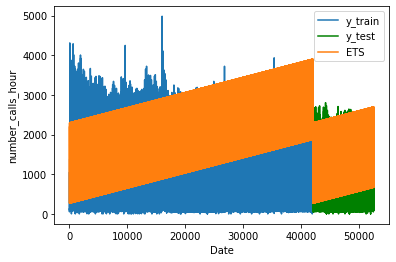

In [53]:
fig, ax = plt.subplots()
sns.lineplot(data=results[results['Set']=="Train"],x="Date",y="number_calls_hour",ax=ax, label = "y_train");
sns.lineplot(data=results[results['Set']=="Test"],x="Date",y="number_calls_hour",ax=ax, label = "y_test", color="green");
sns.lineplot(data=results,x="Date",y="ETS_Predicted",ax=ax, label = "ETS");
plt.show()

In [54]:
fig = px.line(results, x="Date", y="number_calls_hour", color="Set",
              labels={"number_calls_hour": "Number of Calls per Hour", "Date": "Date"})
fig.add_scatter(x=results["Date"], y=results["ETS_Predicted"], mode="lines", name="ETS")
fig.show()

# Error Metrics

In [55]:
mase = MeanAbsoluteScaledError()
mase(y_train, y_train_pred, y_train=y_train)

/usr/local/lib/python3.9/dist-packages/sktime/performance_metrics/forecasting/_classes.py:411: UserWarning:

y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.

/usr/local/lib/python3.9/dist-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning:

y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.



8.831808472278727

In [56]:
mase = MeanAbsoluteScaledError()
mase(y_train, y_train_pred, y_train=y_test)

/usr/local/lib/python3.9/dist-packages/sktime/performance_metrics/forecasting/_classes.py:411: UserWarning:

y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.

/usr/local/lib/python3.9/dist-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning:

y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.



10.819849444353125